# Buoyancy Correlation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import pickle
import time
import datetime
from salishsea_tools import viz_tools
from salishsea_tools import geo_tools
from salishsea_tools import grid_tools
from salishsea_tools import utilities
%matplotlib inline

## Load river discharge data

In [2]:
loadtxt = open('Fraser_flow', 'r')
fraser_discharge = np.loadtxt(loadtxt, usecols =(0,1,2,3), delimiter = ' ')

In [3]:
# Load data from text file into xarray
years, months, days = fraser_discharge[:,0].astype(int), fraser_discharge[:,1].astype(int), fraser_discharge[:,2].astype(int)
discharge_data = fraser_discharge[:,3]

time_array = np.array([])
for date in np.arange(days.shape[0]):
    time_array = np.append(time_array, datetime.datetime(years[date], months[date], days[date]))

data = xr.DataArray(discharge_data, coords = [time_array], dims = ['time'])

In [4]:
# gives data and timeseries from discharge data
def give_data_with_time (xarray, year):
    discharge = xarray.loc[xarray['time.year'].isin([year])].values
    times = xarray.loc[xarray['time.year'].isin([year])].time.values.astype('datetime64[D]').astype(datetime.datetime)
    return (times, discharge)

## Load Salinity timeseries data

In [5]:
salinity = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-06")
times_salinity = salinity.time.sel(time = salinity.time.dt.year.isin([2015,2016,2017,2018])).values.astype('datetime64[s]').astype(datetime.datetime)

In [6]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/salinity/SoG Salinity/sog{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["sog" + str(year)] = pickle.load(file)
    locals()["t" + str(year)] = []
    for time in times_salinity: 
        if time.year == year:
            locals()["t" + str(year)].append(time)  

In [7]:
def average_output(data_array, times, period):

    unique, counts = np.unique(np.asarray(times).astype('datetime64[{}]'.format(period)).astype(datetime.datetime), return_counts=True) 
    index = 0; count_so_far = 0; means = []
    
    for count in counts:
        means.append(np.sum(data_array[count_so_far: count_so_far + count])/count)
        count_so_far = count_so_far + count
        
    return([unique, means])  

In [8]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [9]:
from scipy.stats import linregress

2015
LinregressResult(slope=-0.001012862080835545, intercept=27.609118949487524, rvalue=-0.5380815184027479, pvalue=8.776650442865194e-29, stderr=8.327627118619975e-05)
2016
LinregressResult(slope=-0.0010935155658802218, intercept=27.3760723187505, rvalue=-0.442523112378023, pvalue=5.546856753605999e-19, stderr=0.00011614837628623611)
2017
LinregressResult(slope=-0.0013627464356150453, intercept=27.143857847683694, rvalue=-0.6980727532087366, pvalue=1.3058097493295564e-54, stderr=7.336524212727208e-05)
2018
LinregressResult(slope=-0.001176130415492698, intercept=27.291515511893362, rvalue=-0.683498037853355, pvalue=1.4504776364593714e-51, stderr=6.592640699442706e-05)


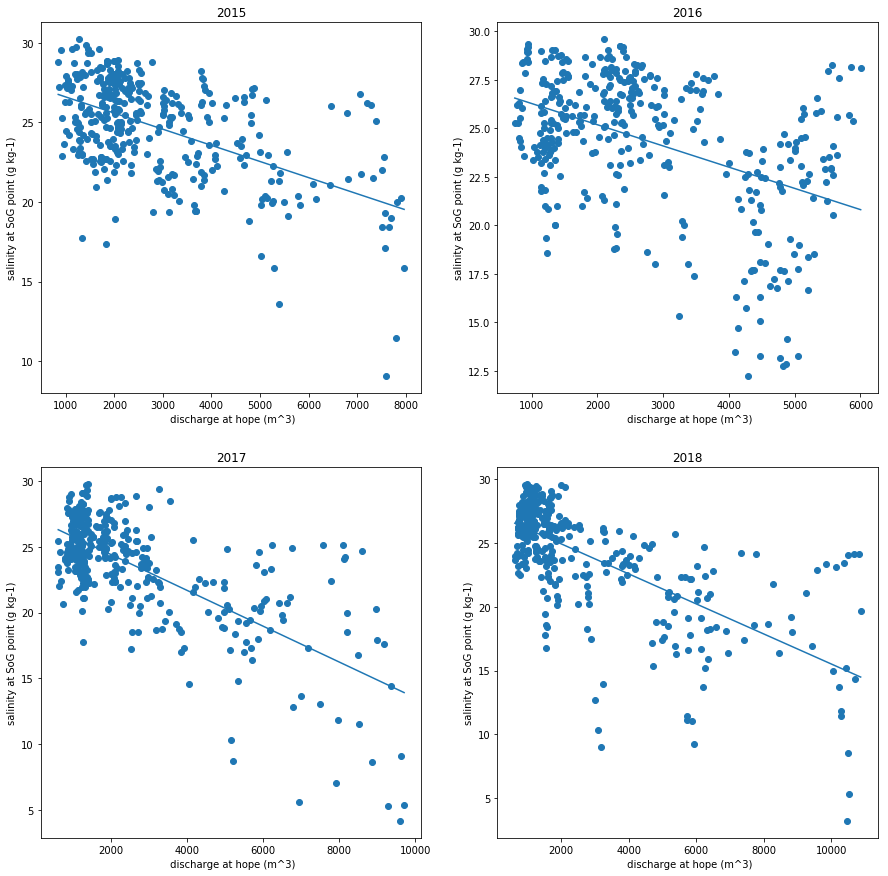

In [10]:
fig = plt.figure(figsize = (15,15))
tick = 1
for year in [2015, 2016, 2017, 2018]:
    plt.subplot(2,2,tick)
    tick = tick + 1
    a = average_output(locals()['sog' + str(year)],locals()['t' + str(year)], 'D')[1]
    b = give_data_with_time(data, year)[1]
    params = linregress(b,a)
    plt.scatter(b,a)
    plt.plot(np.linspace(np.min(b), np.max(b), 10), params[0] * np.linspace(np.min(b), np.max(b), 10) + params[1] )
    plt.xlabel(' discharge at hope (m^3)')
    plt.ylabel('salinity at SoG point (g kg-1)')
    plt.title(year)
    print(year)
    print(params)

## Make plots

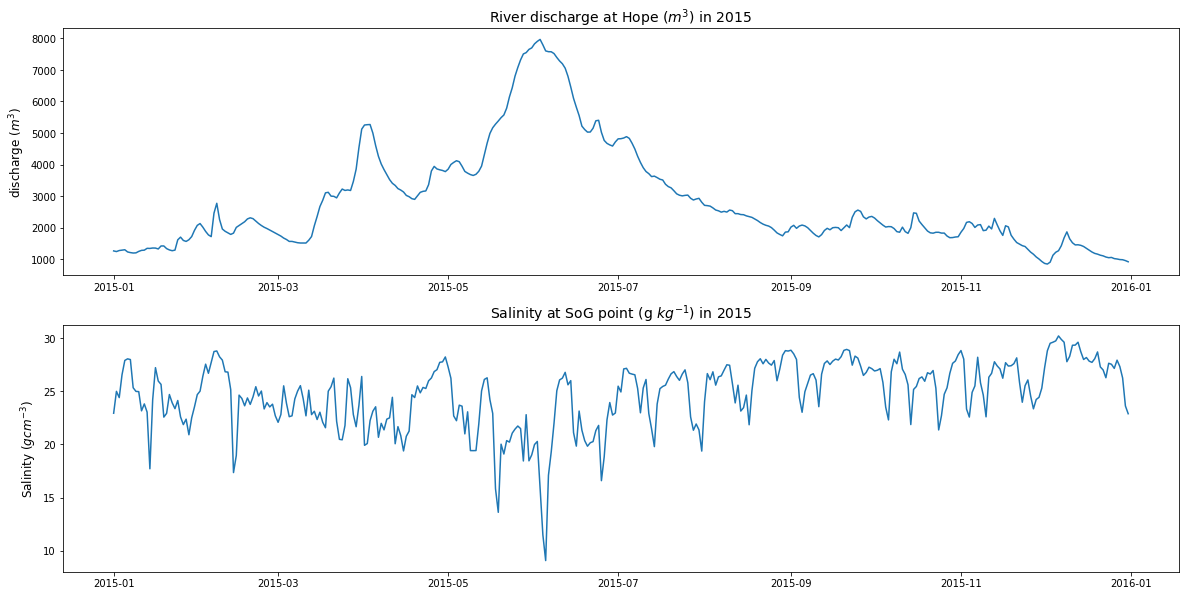

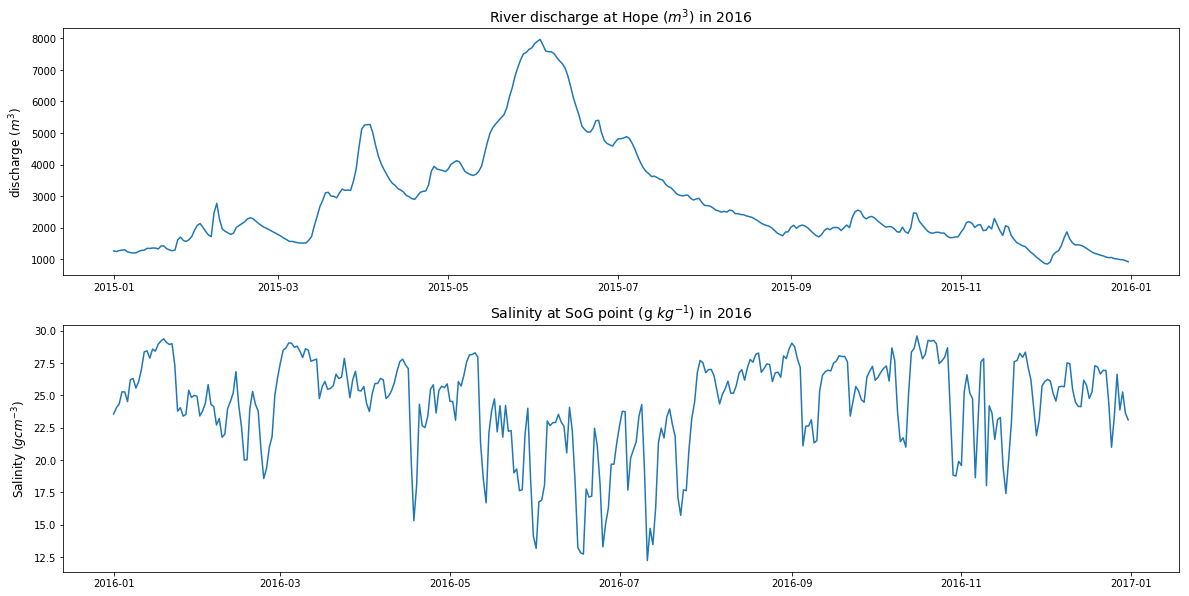

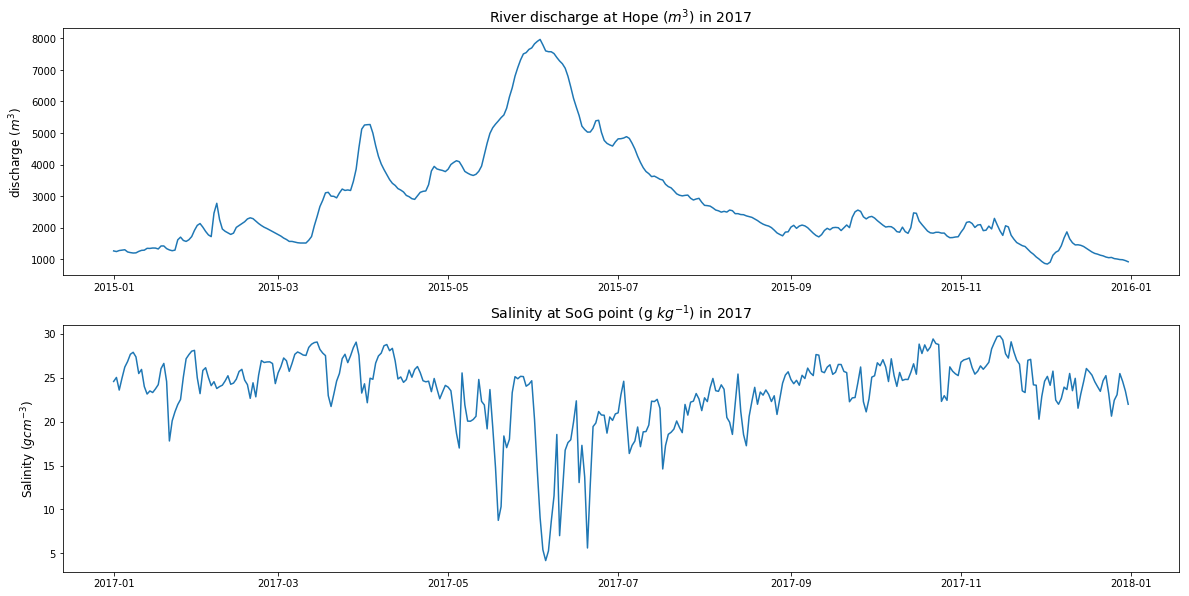

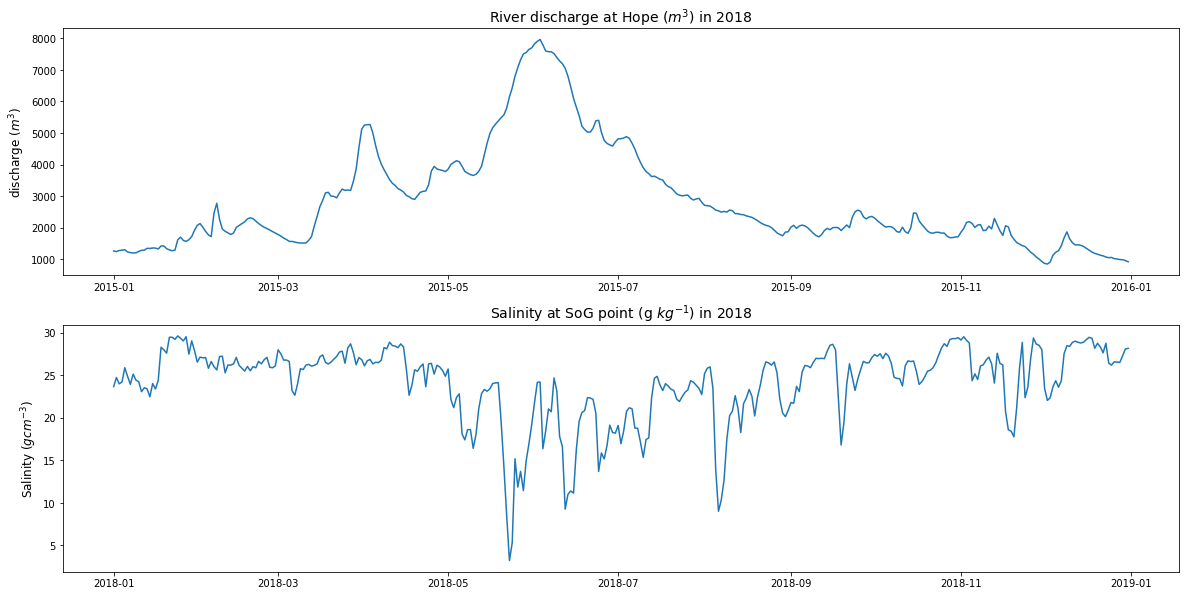

In [15]:
for year in range(2015, 2019):
    fig = plt.figure(figsize = (20,10))
    plt.subplot(2,1,1)
    plot_data = give_data_with_time(data, 2015)
    plt.plot(plot_data[0], plot_data[1])
    plt.ylabel("discharge ($m^{3}$)", fontsize =12)
    plt.title("River discharge at Hope ($m^{3}$)" + " in {}".format(year), fontsize =14)
    plt.subplot(2,1,2)
    salinity_data = average_output(locals()['sog' + str(year)], locals()['t' + str(year)], 'D')
    plt.plot(salinity_data[0], salinity_data[1])
    plt.ylabel("Salinity ($ g {cm^{-3}}$)", fontsize =12)
    plt.title("Salinity at SoG point (g $  { kg^{-1}}$)" + " in {}".format(year), fontsize =14)

In [122]:
# lag : deocrrelation time sclae
# Regression approx sensitivity of salinity vs discharge
# Heat map, slope of scatter plot 
#heatmap fo correlation coeffiecitn
# heat mpa of significance (slope and correlation) t-score
